In [1]:
# # 03_EDA.ipynb
# **Goal:** Perform exploratory data analysis on cleaned Amazon sales data:
# - Compute KPIs
# - Plot time series (monthly/daily revenue)
# - Category / product / region analysis
# - Customer behavior (repeat customers)
# - Quick seasonality / festive check
# - Save aggregated tables and charts for Power BI / reports


In [2]:
# Imports & plotting configuration
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats

# Make sure output folders exist
os.makedirs("../reports/images", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

# Matplotlib style (minimal)
plt.rcParams.update({
    "figure.figsize": (10,5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 11
})

# Helper to format INR-like numbers (no currency symbol)
def fmt_thousands(x, pos):
    if x >= 1e7:
        return f"{x/1e7:.1f} Cr"
    if x >= 1e5:
        return f"{x/1e5:.1f} L"
    return f"{int(x):,}"


In [3]:
# Path to cleaned dataset (adjust if needed)
clean_path = "../data/processed/Amazon_Sales_Cleaned.csv"
if not os.path.exists(clean_path):
    raise FileNotFoundError(f"Cleaned file not found at {clean_path} — run cleaning notebook first.")

df = pd.read_csv(clean_path, parse_dates=['Date'], low_memory=False)
print("Loaded cleaned data:", clean_path)
print("Shape:", df.shape)
df.head()


Loaded cleaned data: ../data/processed/Amazon_Sales_Cleaned.csv
Shape: (116269, 30)


,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,...,B2B,fulfilled-by,Amount_raw,Total_Amount,Unit_Price,Year,Month,Day,Month_Year,Order_MonthStart
0,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,Kurta,3XL,...,False,Easy Ship,406.0,406.0,406.0,2022,4,30,2022-04,2022-04-01
1,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,Kurta,XL,...,True,Unknown,329.0,329.0,329.0,2022,4,30,2022-04,2022-04-01
2,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,False,Unknown,574.0,574.0,574.0,2022,4,30,2022-04,2022-04-01
3,404-1490984-4578765,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,SET264,SET264-KR-NP-XL,Set,XL,...,False,Unknown,824.0,824.0,824.0,2022,4,30,2022-04,2022-04-01
4,408-5748499-6859555,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,J0095,J0095-SET-L,Set,L,...,False,Unknown,653.0,653.0,653.0,2022,4,30,2022-04,2022-04-01


In [4]:
# KPIs
total_revenue = df['Total_Amount'].sum()
num_orders = df['Order ID'].nunique() if 'Order ID' in df.columns else df.shape[0]
unique_customers = df['Customer ID'].nunique() if 'Customer ID' in df.columns else "N/A"
avg_order_value = df['Total_Amount'].mean()
median_order_value = df['Total_Amount'].median()

kpis = {
    "Total Revenue": total_revenue,
    "Number of Orders": num_orders,
    "Unique Customers": unique_customers,
    "Avg Order Value": avg_order_value,
    "Median Order Value": median_order_value
}

# Display KPIs
for k,v in kpis.items():
    if isinstance(v,(int,float)):
        print(f"{k:20s} : {v:,.2f}")
    else:
        print(f"{k:20s} : {v}")


Total Revenue        : 75,399,871.00
Number of Orders     : 108,419.00
Unique Customers     : N/A
Avg Order Value      : 649.77
Median Order Value   : 606.00


C:\Users\Utkarsh Pal\AppData\Local\Temp\ipykernel_29004\1570288042.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M', on='Date')['Total_Amount'].sum().reset_index().sort_values('Date')


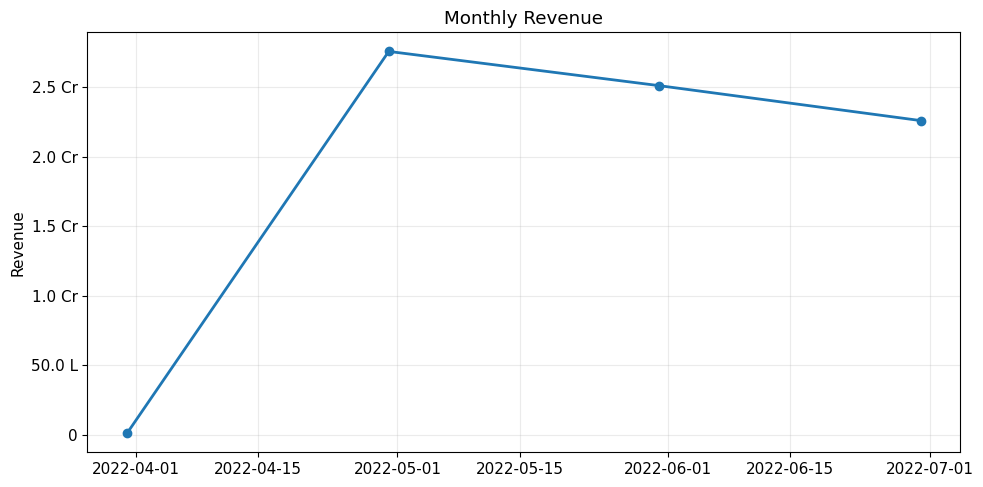

In [5]:
# Aggregations
df['Date_only'] = df['Date'].dt.date
daily = df.groupby('Date_only')['Total_Amount'].sum().reset_index()
weekly = df.resample('W-MON', on='Date')['Total_Amount'].sum().reset_index().sort_values('Date')
monthly = df.resample('M', on='Date')['Total_Amount'].sum().reset_index().sort_values('Date')

# Plot monthly revenue
fig, ax = plt.subplots()
ax.plot(monthly['Date'], monthly['Total_Amount'], marker='o', linewidth=2)
ax.set_title("Monthly Revenue")
ax.set_ylabel("Revenue")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
plt.tight_layout()
plt.savefig("../reports/images/monthly_revenue.png", dpi=150)
plt.show()


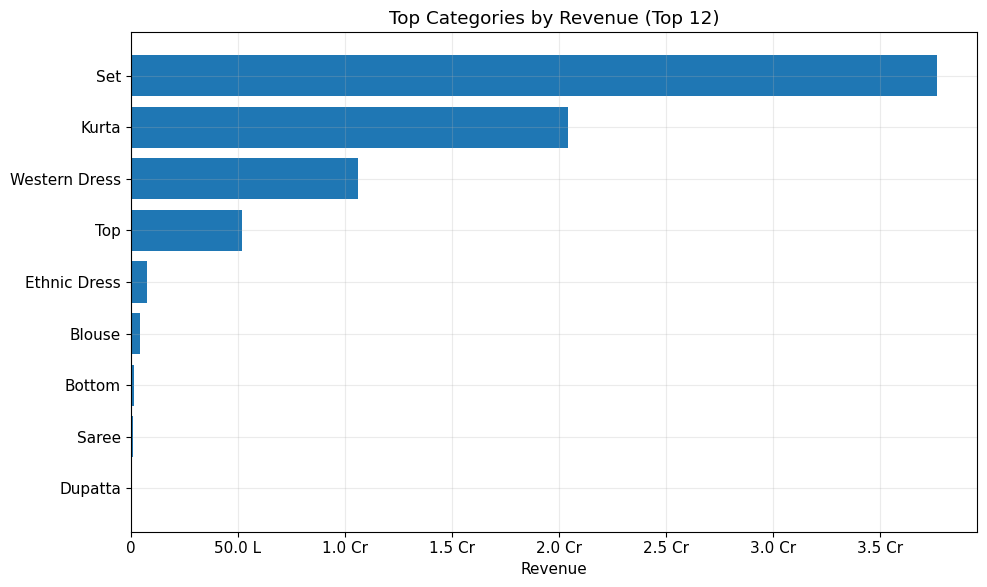

,Total_Amount,count
Category,,
Set,37660322.0,45192
Kurta,20451608.0,44861
Western Dress,10629096.0,13903
Top,5203733.0,9876
Ethnic Dress,760711.0,1051
Blouse,434751.0,841
Bottom,140226.0,394
Saree,118509.0,148
Dupatta,915.0,3


In [6]:
if 'Category' in df.columns:
    cat_rev = df.groupby('Category')['Total_Amount'].sum().sort_values(ascending=False)
    cat_count = df['Category'].value_counts()
    top_cat = cat_rev.head(12)

    # Bar chart revenue by category
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(top_cat.index[::-1], top_cat.values[::-1])
    ax.set_title("Top Categories by Revenue (Top 12)")
    ax.set_xlabel("Revenue")
    ax.xaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    plt.tight_layout()
    plt.savefig("../reports/images/top_categories_revenue.png", dpi=150)
    plt.show()

    display(pd.concat([cat_rev.head(10), cat_count.head(10)], axis=1).rename(columns={0:'Revenue', 'Category':'Order Count'}).head(10))
else:
    print("No 'Category' column found.")


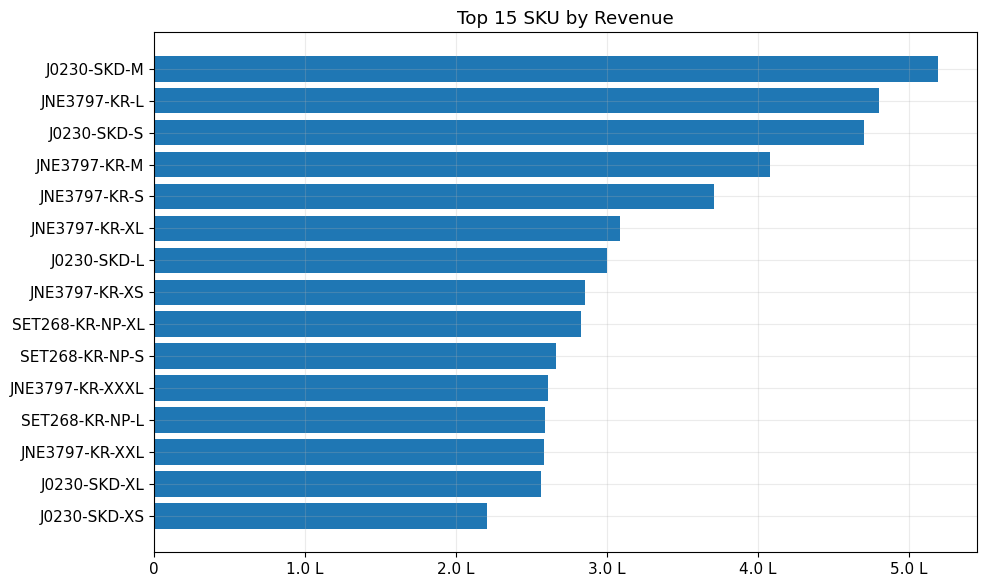

In [7]:
# Attempt 'Product' or 'SKU' depending on availability
product_col = None
for c in ['Product','SKU','ASIN']:
    if c in df.columns:
        product_col = c
        break

if product_col:
    prod_rev = df.groupby(product_col)['Total_Amount'].sum().sort_values(ascending=False).head(15)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(prod_rev.index[::-1], prod_rev.values[::-1])
    ax.set_title(f"Top 15 {product_col} by Revenue")
    ax.xaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    plt.tight_layout()
    plt.savefig("../reports/images/top_products.png", dpi=150)
    plt.show()
else:
    print("No product identifier column (Product/SKU/ASIN) found.")


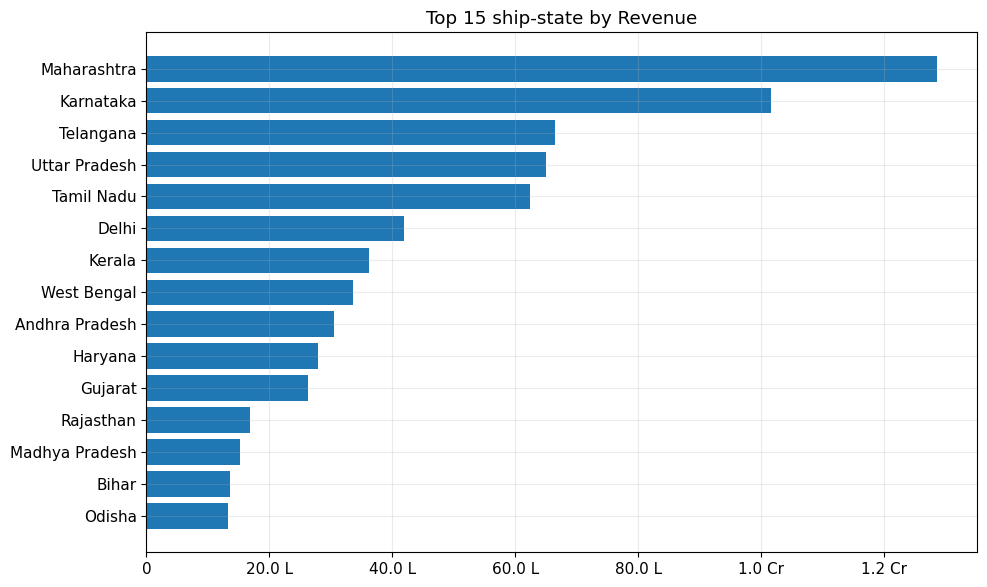

In [8]:
# Prefer 'ship-state' then 'ship-city'
region_col = 'ship-state' if 'ship-state' in df.columns else ('ship-city' if 'ship-city' in df.columns else None)

if region_col:
    region_rev = df.groupby(region_col)['Total_Amount'].sum().sort_values(ascending=False).head(15)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(region_rev.index[::-1], region_rev.values[::-1])
    ax.set_title(f"Top 15 {region_col} by Revenue")
    ax.xaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    plt.tight_layout()
    plt.savefig(f"../reports/images/top_{region_col}_revenue.png", dpi=150)
    plt.show()
else:
    print("No ship-state or ship-city column present.")


In [9]:
if 'Customer ID' in df.columns:
    cust_orders = df.groupby('Customer ID')['Order ID'].nunique().rename('num_orders')
    cust_rev = df.groupby('Customer ID')['Total_Amount'].sum().rename('total_spend')
    cust_summary = pd.concat([cust_orders, cust_rev], axis=1).sort_values('num_orders', ascending=False)
    display(cust_summary.head(10))

    # Repeat customer ratio
    repeat_count = (cust_summary['num_orders'] > 1).sum()
    total_customers = cust_summary.shape[0]
    print(f"Repeat customers: {repeat_count} / {total_customers} ({repeat_count/total_customers:.2%})")

    # Distribution of orders per customer
    fig, ax = plt.subplots()
    ax.hist(cust_summary['num_orders'], bins=20)
    ax.set_title("Distribution: Orders per Customer")
    ax.set_xlabel("Number of Orders")
    plt.tight_layout()
    plt.savefig("../reports/images/orders_per_customer_hist.png", dpi=150)
    plt.show()
else:
    print("No 'Customer ID' column found — skip customer-level analysis.")


No 'Customer ID' column found — skip customer-level analysis.


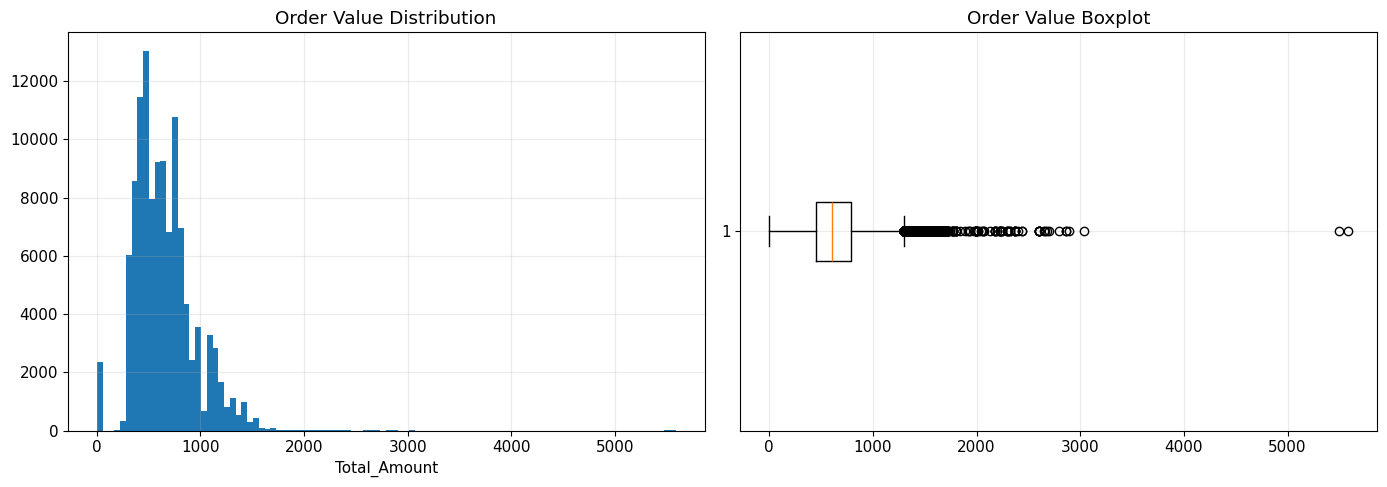

In [10]:
# Distribution & boxplot for order values
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(df['Total_Amount'], bins=100)
ax[0].set_title("Order Value Distribution")
ax[0].set_xlabel("Total_Amount")

# Boxplot (log-scale to handle skew)
ax[1].boxplot(df['Total_Amount'].dropna(), vert=False)
ax[1].set_title("Order Value Boxplot")
plt.tight_layout()
plt.savefig("../reports/images/order_value_dist_boxplot.png", dpi=150)
plt.show()


C:\Users\Utkarsh Pal\AppData\Local\Temp\ipykernel_29004\2034972001.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = df.resample('M', on='Date')['Total_Amount'].sum().reset_index()


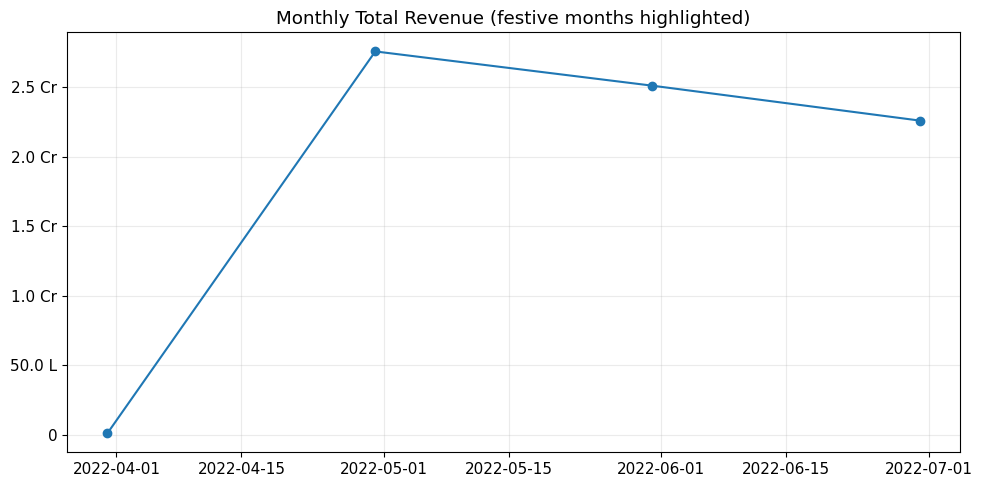

Festive orders: 0 Non-festive orders: 116269
t-stat: nan p-value: nan


C:\Users\Utkarsh Pal\AppData\Roaming\Python\Python313\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [11]:
# Mark festive months (Nov, Dec) as example
df['Month'] = df['Date'].dt.month
df['is_festive'] = df['Month'].isin([11,12])

monthly_totals = df.resample('M', on='Date')['Total_Amount'].sum().reset_index()
monthly_totals['is_festive'] = monthly_totals['Date'].dt.month.isin([11,12])

# Plot monthly totals with festive annotation
fig, ax = plt.subplots()
ax.plot(monthly_totals['Date'], monthly_totals['Total_Amount'], marker='o')
ax.set_title("Monthly Total Revenue (festive months highlighted)")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
# highlight festive months
festive_points = monthly_totals[monthly_totals['is_festive']]
ax.scatter(festive_points['Date'], festive_points['Total_Amount'], color='red', zorder=5)
plt.tight_layout()
plt.savefig("../reports/images/monthly_with_festive.png", dpi=150)
plt.show()

# Quick statistical compare: per-order amounts in festive vs non-festive (note: this is exploratory)
festive_orders = df[df['is_festive']]['Total_Amount']
nonfestive_orders = df[~df['is_festive']]['Total_Amount']
print("Festive orders:", festive_orders.shape[0], "Non-festive orders:", nonfestive_orders.shape[0])
tstat, pval = stats.ttest_ind(festive_orders.dropna(), nonfestive_orders.dropna(), equal_var=False)
print("t-stat:", tstat, "p-value:", pval)


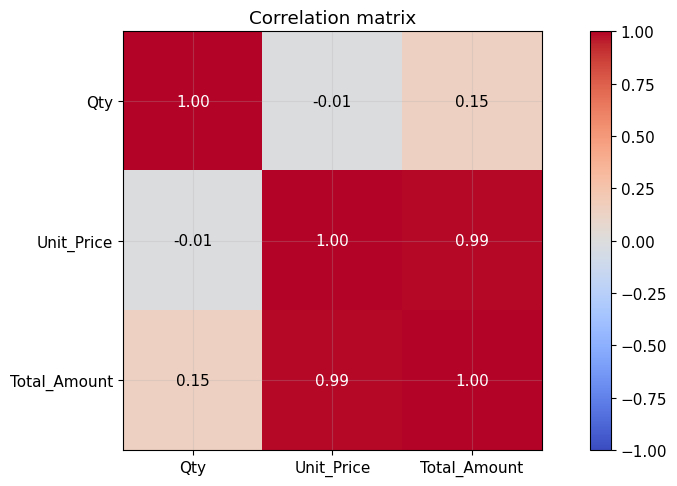

In [12]:
num_cols = [c for c in ['Qty','Unit_Price','Total_Amount'] if c in df.columns]
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    fig, ax = plt.subplots()
    im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(len(num_cols))); ax.set_yticks(range(len(num_cols)))
    ax.set_xticklabels(num_cols); ax.set_yticklabels(num_cols)
    for (i,j), val in np.ndenumerate(corr.values):
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val)>0.5 else 'black')
    fig.colorbar(im)
    ax.set_title("Correlation matrix")
    plt.tight_layout()
    plt.savefig("../reports/images/numeric_correlation.png", dpi=150)
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")


In [13]:
# Save aggregates used in dashboard
monthly.to_csv("../data/processed/agg_monthly_revenue.csv", index=False)
cat_rev = df.groupby('Category')['Total_Amount'].sum().reset_index().sort_values('Total_Amount', ascending=False)
cat_rev.to_csv("../data/processed/agg_category_revenue.csv", index=False)
if product_col:
    df.groupby(product_col)['Total_Amount'].sum().reset_index().sort_values('Total_Amount', ascending=False).head(50).to_csv("../data/processed/agg_top_products.csv", index=False)

print("Saved: monthly, category, top products aggregates to data/processed/")


Saved: monthly, category, top products aggregates to data/processed/


In [14]:
# ## Quick EDA Notes / Findings (to update with narrative)
# - Total revenue: see KPIs above.
# - Monthly trend: refer to saved plot `reports/images/monthly_revenue.png`.
# - Top categories & products identified for further focus.
# - Festive months (Nov–Dec) show highlighted spikes — we'll test significance in the statistical notebook.
# - Next: create SQL queries for key metrics, refine visuals for Power BI, and start forecasting (time-series).
